In [1]:
#tools
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper


In [2]:
api_wrapper=ArxivAPIWrapper()
arxiv_tool=ArxivQueryRun(api_wrapper=api_wrapper,top_k=2,description="Search for papers on arxiv.org")
print(arxiv_tool.name)

arxiv


In [3]:
arxiv_tool.invoke("What is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from lab research to commercial products in the\npast decade as it plays an increasingly crucial role in data communication for\nnext-generation data centers and high performance computing1. Recently,\nprogrammable silicon photonics has also found new applications in quantum2 and\nclassical 3 information processing. A key component of programmable silicon\nphotonic integrated circuits (PICs) is the phase shifter, traditionally\nrealized via the thermo-optic or plasma dispersion effect which are weak,\nvolatile, and power hungry. A non-volatile phase shifter can circumvent these\nlimitations by requiring zero power to maintain the switched phases. Previously\nnon-volatile phase modulation was

In [4]:
wiki_wrapper=WikipediaAPIWrapper()
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_wrapper,top_k=2,description="Search for articles on Wikipedia")
print(wiki_tool.name)


wikipedia


In [5]:
# Make sure wiki_tool is defined
wiki_tool.invoke("What is the history of quantum computing?")

'Page: Timeline of quantum computing and communication\nSummary: This is a timeline of quantum computing and communication.\n\nPage: Institute for Quantum Computing\nSummary: The Institute for Quantum Computing (IQC) is an affiliate scientific research institute of the University of Waterloo located in Waterloo, Ontario with a multidisciplinary approach to the field of quantum information processing. IQC was founded in 2002 primarily through a donation made by Mike Lazaridis and his wife Ophelia whose substantial donations have continued over the years.  The institute is now located in the Mike & Ophelia Lazaridis Quantum-Nano Centre and the Research Advancement Centre at the University of Waterloo.\nIts executive director is physics professor Norbert Lütkenhaus and hosts researchers based in 7 departments across 3 faculties at the University of Waterloo. In addition to theoretical and experimental research on quantum computing, IQC also hosts academic conferences and workshops, short 

In [10]:
from dotenv import load_dotenv
import os

# If .env is in a different location, specify the path
load_dotenv()  # or load_dotenv('/path/to/your/.env')

# Add error checking
groq_key = os.getenv("Groq_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

if groq_key is None:
    print("Error: Groq_API_KEY not found in environment variables")
else:
    os.environ["Groq_API_KEY"] = groq_key

if tavily_key is None:
    print("Error: TAVILY_API_KEY not found in environment variables")
else:
    os.environ["TAVILY_API_KEY"] = tavily_key

In [11]:
from langchain_tavily import TavilySearch

tavily = TavilySearch()

In [12]:
tavily.invoke("What is the latest research on quantum computing?")

{'query': 'What is the latest research on quantum computing?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://phys.org/tags/quantum+computing/',
   'title': 'Quantum Computing - latest research news and features - Phys.org',
   'content': 'News on quantum computing · Improving randomness may be the key to more powerful quantum computers · Quantum computer simulates spontaneous symmetry breaking at',
   'score': 0.78709817,
   'raw_content': None},
  {'url': 'https://www.sciencedaily.com/news/computers_math/quantum_computers/',
   'title': 'Quantum Computers News - ScienceDaily',
   'content': 'June 8, 2025 — A team of researchers has shown that even small-scale quantum computers can enhance machine learning performance, using a novel photonic quantum',
   'score': 0.72814995,
   'raw_content': None},
  {'url': 'https://thequantuminsider.com/',
   'title': 'The Quantum Insider: Quantum Computing News & Top Stories',
   'content': 'Find the la

In [13]:
tools=[
    arxiv_tool,
    wiki_tool,
    tavily
]

In [14]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="deepseek-r1-distill-llama-70b")




In [15]:
#binding the tool with the llm 
llm_with_tools=llm.bind_tools(tools)

In [16]:
llm_with_tools.invoke("What is the latest research on quantum computing?")

AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the latest research on quantum computing. I should use the arxiv tool to search for recent papers on this topic. Arxiv is a great resource for preprints in physics, computer science, and related fields. Since the user is interested in the latest research, I'll set the time range to the past week to get the most recent submissions. That way, the results will be up-to-date and relevant. I'll structure the tool call with the query and the appropriate time range parameter.\n", 'tool_calls': [{'id': '1r2e6dqq9', 'function': {'arguments': '{"query":"quantum computing","time_range":"week"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 1155, 'total_tokens': 1291, 'completion_time': 0.541499406, 'prompt_time': 0.090467092, 'queue_time': 0.09306551099999999, 'total_time': 0.631966498}, 'model_name': 'deepseek-r1-distill-llama-70b

## workflow

In [17]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated 
from langgraph.graph.message import add_messages


In [18]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import (ToolNode,tools_condition)

In [20]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
            

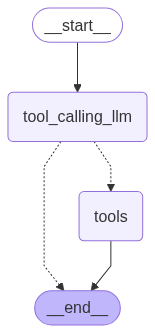

In [21]:
# Build Build the the workflow graph workfl
graph = StateGraph(State)

graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

#Edges

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    )

graph.add_edge("tools", END)

graphbuilder=graph.compile()

display(Image(graphbuilder.get_graph().draw_mermaid_png()))


In [22]:
messages = graphbuilder.invoke({
    "messages": "What is the latest research on quantum computing?"
})

for m in messages['messages']:
   m.pretty_print()

================================ Human Message =================================

What is the latest research on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  arxiv (merxgs330)
 Call ID: merxgs330
  Args:
    query: quantum computing latest research
================================= Tool Message =================================
Name: arxiv

Published: 2023-01-27
Title: A Living Review of Quantum Computing for Plasma Physics
Authors: Óscar Amaro, Diogo Cruz
Summary: Quantum Computing promises accelerated simulation of certain classes of
problems, in particular in plasma physics. Given the nascent interest in
applying quantum computing techniques to study plasma systems, a compendium of
the relevant literature would be most useful. As a novel field, new results are
common, and it is important for researchers to stay up-to-date on the latest
developments. With this in mind, the goal of this document is to provide a
regul

In [23]:
messages = graphbuilder.invoke({
    "messages": "What is the latest research on quantum computing and what  is Machine learning?"
})

for m in messages['messages']:
   m.pretty_print()

================================ Human Message =================================

What is the latest research on quantum computing and what  is Machine learning?
================================== Ai Message ==================================
Tool Calls:
  arxiv (9apgyzsyv)
 Call ID: 9apgyzsyv
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: arxiv

Published: 2022-08-01
Title: The Rise of Quantum Internet Computing
Authors: Seng W. Loke
Summary: This article highlights quantum Internet computing as referring to
distributed quantum computing over the quantum Internet, analogous to
(classical) Internet computing involving (classical) distributed computing over
the (classical) Internet. Relevant to quantum Internet computing would be areas
of study such as quantum protocols for distributed nodes using quantum
information for computations, quantum cloud computing, delegated verifiable
blind or private computing, non

In [24]:
messages = graphbuilder.invoke({
    "messages": "my name is Adil Hayat"
})

for m in messages['messages']:
   m.pretty_print()

================================ Human Message =================================

my name is Adil Hayat
================================== Ai Message ==================================

Thank you for sharing your name, Adil Hayat! How can I assist you today?


# Second diagram 

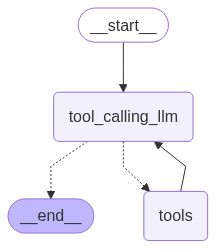

In [25]:
# Build Build the the workflow graph workfl
graph = StateGraph(State)

graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

#Edges

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    )

graph.add_edge("tools", "tool_calling_llm")

graphbuilder1=graph.compile()

display(Image(graphbuilder1.get_graph().draw_mermaid_png()))


In [26]:
messages = graphbuilder1.invoke({
    "messages": "What is the latest research on quantum computing and what  is Machine learning?"
})

for m in messages['messages']:
   m.pretty_print()

================================ Human Message =================================

What is the latest research on quantum computing and what  is Machine learning?
================================== Ai Message ==================================
Tool Calls:
  arxiv (z1nrgnsj4)
 Call ID: z1nrgnsj4
  Args:
    query: latest research quantum computing machine learning
================================= Tool Message =================================
Name: arxiv

Published: 2025-02-03
Title: Quantum Machine Learning: A Hands-on Tutorial for Machine Learning Practitioners and Researchers
Authors: Yuxuan Du, Xinbiao Wang, Naixu Guo, Zhan Yu, Yang Qian, Kaining Zhang, Min-Hsiu Hsieh, Patrick Rebentrost, Dacheng Tao
Summary: This tutorial intends to introduce readers with a background in AI to quantum
machine learning (QML) -- a rapidly evolving field that seeks to leverage the
power of quantum computers to reshape the landscape of machine learning. For
self-consistency, this tutorial covers founda

In [28]:
messages = graphbuilder.invoke({
    "messages": "my name is Adil Hayat  and give me the research on machine learning ?"
})

for m in messages['messages']:
   m.pretty_print()

================================ Human Message =================================

my name is Adil Hayat  and give me the research on machine learning ?
================================== Ai Message ==================================
Tool Calls:
  arxiv (b92rk212r)
 Call ID: b92rk212r
  Args:
    query: machine learning
================================= Tool Message =================================
Name: arxiv

Published: 2019-09-08
Title: Lecture Notes: Optimization for Machine Learning
Authors: Elad Hazan
Summary: Lecture notes on optimization for machine learning, derived from a course at
Princeton University and tutorials given in MLSS, Buenos Aires, as well as
Simons Foundation, Berkeley.

Published: 2018-11-11
Title: An Optimal Control View of Adversarial Machine Learning
Authors: Xiaojin Zhu
Summary: I describe an optimal control view of adversarial machine learning, where the
dynamical system is the machine learner, the input are adversarial actions, and
the control costs are d

In [29]:
messages = graphbuilder.invoke({
    "messages": "what is my name "
})

for m in messages['messages']:
   m.pretty_print()

================================ Human Message =================================

what is my name 
================================== Ai Message ==================================

I can't access personal information, but feel free to share if you'd like!


## ADD the Memory 

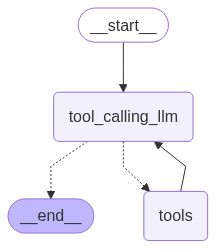

In [45]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()
# Build Build the the workflow graph workflow
graph = StateGraph(State)


graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

#Edges

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    )

graph.add_edge("tools", "tool_calling_llm")

graphbuilder1=graph.compile(checkpointer=memory)

display(Image(graphbuilder1.get_graph().draw_mermaid_png()))


In [46]:
config = {"configurable": {"thread_id": "1"}}

response = graphbuilder1.invoke(
    {
        "messages": "my name is Adil hayat?"
    },
    config=config
)


In [47]:
response['messages'][-1].content

"It seems like you might be looking for information about yourself or someone else named Adil Hayat. Could you clarify what you're seeking? For example, are you looking for professional information, personal details, or something else?"

In [48]:
response = graphbuilder1.invoke(
    {
        "messages": "what is my name ?"
    },
    config=config
)


In [51]:
print(response['messages'][-1].content)

I don't have access to personal information, including your name. If you're looking for your name associated with this chat or any other platform, you may need to check your account settings or contact the support team for assistance. Let me know if you have any other questions!


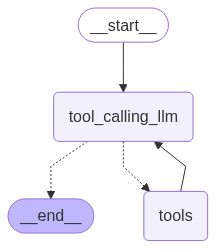

Alternative approach with conversation history:
First response:
Hello Engr Adil Hayat! Thank you for introducing yourself. I've noted your name and will address you accordingly in our conversation. How can I assist you today?

------------------------------

Second response:
Hello Engr Adil Hayat! Your name is Engr Adil Hayat. How can I assist you today?

------------------------------

Full conversation history:
Message 1 (HumanMessage): Hi, my name is Engr Adil Hayat. Please remember this.
Message 2 (AIMessage): Hello Engr Adil Hayat! Thank you for introducing yourself. I've noted your name and will address you accordingly in our conversation. How can I assist you today?
Message 3 (HumanMessage): What is my name?
Message 4 (AIMessage): Hello Engr Adil Hayat! Your name is Engr Adil Hayat. How can I assist you today?


In [56]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

# Initialize memory
memory = MemorySaver()

# Build the workflow graph
graph = StateGraph(State)

# Add nodes
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

# Add edges
graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
graph.add_edge("tools", "tool_calling_llm")

# Compile the graph
graphbuilder1 = graph.compile(checkpointer=memory)

# Display the graph
display(Image(graphbuilder1.get_graph().draw_mermaid_png()))


# This approach preserves the full conversation history
print("Alternative approach with conversation history:")

# Start fresh with a new thread
config_new = {"configurable": {"thread_id": "6"}}

# First message
response1 = graphbuilder1.invoke(
    {
        "messages": [HumanMessage(content="Hi, my name is Engr Adil Hayat. Please remember this.")]
    },
    config=config_new
)

print("First response:")
print(response1["messages"][-1].content)
print("\n" + "-"*30 + "\n")

# Second message - should remember the name
response2 = graphbuilder1.invoke(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new
)

print("Second response:")
print(response2["messages"][-1].content)
print("\n" + "-"*30 + "\n")

# You can also check the conversation history
print("Full conversation history:")
for i, msg in enumerate(response2["messages"]):
    print(f"Message {i+1} ({type(msg).__name__}): {msg.content}")

## 🚀 Convert the Response to the Streaming Format

## Streaming in LangGraph

LangGraph provides **two methods for streaming results**:

- `.stream()` → **sync streaming**
- `.astream()` → **async streaming**

---

## Streaming Modes for Graph State

You can control **what type of streaming data you receive** using:

- `stream_mode="values"`
- `stream_mode="updates"`

---

## What each mode means

✅ **`values`:**

- Streams the **full state of the graph after each node finishes**.
- Shows **all data produced by the node** before moving to the next node.

✅ **`updates`:**

- Streams **partial updates to the graph’s state immediately after each node is called**.
- Provides **finer-grained, faster updates** (e.g., partial tokens while an LLM generates or a tool call starts/finishes).


In [60]:
import time
# Method 1: Stream just the final response content
print("Second response (streaming - clean output):")
for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new,
    stream_mode="values"
):
    # Get the latest message from the chunk
    if "messages" in chunk and chunk["messages"]:
        latest_message = chunk["messages"][-1]
        # Only print if it's an AI message (response)
        if hasattr(latest_message, 'content') and latest_message.content:
            print(latest_message.content, end="", flush=True)

print("\n" + "-"*30 + "\n")

# Method 2: Stream with proper formatting and only show new content
print("Second response (streaming - no duplicates):")
previous_content = ""
for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new,
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        latest_message = chunk["messages"][-1]
        if hasattr(latest_message, 'content') and latest_message.content:
            current_content = latest_message.content
            # Only print new content (avoid duplicates)
            if current_content != previous_content:
                new_content = current_content[len(previous_content):]
                print(new_content, end="", flush=True)
                previous_content = current_content

print("\n" + "-"*30 + "\n")

# Method 3: Stream with updates mode (shows step-by-step processing)
print("Second response (streaming - with processing steps):")
for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new,
    stream_mode="updates"
):
    for node_name, node_data in chunk.items():
        if node_name == "tool_calling_llm" and "messages" in node_data:
            latest_message = node_data["messages"][-1]
            if hasattr(latest_message, 'content') and latest_message.content:
                print(f"[{node_name}]: {latest_message.content}")

print("\n" + "-"*30 + "\n")

# Method 4: Stream word by word for better visual effect
print("Second response (streaming - word by word):")
for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new,
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        latest_message = chunk["messages"][-1]
        if hasattr(latest_message, 'content') and latest_message.content:
            # Split into words and print with small delay
            words = latest_message.content.split()
            for word in words:
                print(word, end=" ", flush=True)
                time.sleep(0.1)  # Small delay between words

print("\n" + "-"*30 + "\n")

# Method 5: Stream with typing indicator
print("Second response (streaming - with typing effect):")
import time

# Show typing indicator
for i in range(3):
    print("Assistant is typing" + "." * (i + 1), end="\r", flush=True)
    time.sleep(0.5)

print("Assistant: ", end="", flush=True)

for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new,
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        latest_message = chunk["messages"][-1]
        if hasattr(latest_message, 'content') and latest_message.content:
            # Character by character streaming
            for char in latest_message.content:
                print(char, end="", flush=True)
                time.sleep(0.03)  # Adjust speed as needed

print("\n" + "-"*30 + "\n")

# Method 6: Stream with error handling and clean output
print("Second response (streaming - with error handling):")
try:
    response_text = ""
    for chunk in graphbuilder1.stream(
        {
            "messages": [HumanMessage(content="What is my name?")]
        },
        config=config_new,
        stream_mode="values"
    ):
        if "messages" in chunk and chunk["messages"]:
            latest_message = chunk["messages"][-1]
            if hasattr(latest_message, 'content') and latest_message.content:
                current_content = latest_message.content
                if current_content != response_text:
                    # Print only the new part
                    new_part = current_content[len(response_text):]
                    print(new_part, end="", flush=True)
                    response_text = current_content
    
    print(f"\n[Response completed: {len(response_text)} characters]")
    
except Exception as e:
    print(f"Error during streaming: {e}")

print("\n" + "-"*30 + "\n")

# Method 7: Complete conversation with streaming
print("Complete conversation example:")
print("User: My name is John Doe")
print("Assistant: ", end="", flush=True)

# First message
for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="My name is John Doe")]
    },
    config=config_new,
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        latest_message = chunk["messages"][-1]
        if hasattr(latest_message, 'content') and latest_message.content:
            print(latest_message.content, end="", flush=True)

print("\n")
print("User: What is my name?")
print("Assistant: ", end="", flush=True)

# Second message - should remember the name
for chunk in graphbuilder1.stream(
    {
        "messages": [HumanMessage(content="What is my name?")]
    },
    config=config_new,
    stream_mode="values"
):
    if "messages" in chunk and chunk["messages"]:
        latest_message = chunk["messages"][-1]
        if hasattr(latest_message, 'content') and latest_message.content:
            print(latest_message.content, end="", flush=True)

print("\n" + "="*50 + "\n")

Second response (streaming - clean output):
What is my name?

Your name is **Engr Adil Hayat**. How can I assist you today?
------------------------------

Second response (streaming - no duplicates):
What is my name?
------------------------------

Second response (streaming - with processing steps):
[tool_calling_llm]: Your name is **Engr Adil Hayat**. How can I assist you today?

------------------------------

Second response (streaming - word by word):
What is my name? Your name is **Engr Adil Hayat**. How can I assist you today? 
------------------------------

Second response (streaming - with typing effect):
Assistant: s typing...What is my name?Your name is **Engr Adil Hayat**. How can I assist you today?
------------------------------

Second response (streaming - with error handling):
What is my name?ngr Adil Hayat**. How can I assist you today?
[Response completed: 61 characters]

------------------------------

Complete conversation example:
User: My name is John Doe
Assistant: My name is John DoeIt seems there might be some confusio